In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [2]:
news_train = fetch_20newsgroups(subset='train', remove=(['headers' 'footers', 'quotes']), shuffle=True,random_state=99)
news_test = fetch_20newsgroups(subset='test',remove=(['headers' 'footers', 'quotes']),shuffle=True,random_state=42)

Feature Engineering

In [3]:
news_train.data = [word.replace("\n", " ") for word in news_train.data]
news_train.data = [word.replace("\r", " ") for word in news_train.data]
news_train.data = [word.replace("\t", " ") for word in news_train.data]
news_train.data = [word.replace('"', " ") for word in news_train.data]
news_train.data = [word.lower() for word in news_train.data]
punctuation_signs = list("?:!.,;@*-=")
for sign in punctuation_signs:
    news_train.data = [word.replace(sign, " ") for word in news_train.data]
news_train.data = [word.replace("'s", " ") for word in news_train.data]

In [4]:
from collections import defaultdict
new_dict = defaultdict(list)
for data in range(len(news_train.data)):
    new_dict[news_train.target_names[news_train.target[data]]].append(len(news_train.data[data]))

In [5]:
dict_df = pd.DataFrame([v for k,v in new_dict.items()])
new_dict_df = dict_df.transpose()
new_dict_df.columns = [k for k in new_dict.keys()]
new_dict_df.head()

,rec.autos,rec.sport.baseball,soc.religion.christian,comp.windows.x,sci.electronics,talk.politics.guns,comp.os.ms-windows.misc,talk.religion.misc,comp.sys.ibm.pc.hardware,rec.sport.hockey,misc.forsale,alt.atheism,rec.motorcycles,talk.politics.misc,comp.graphics,sci.crypt,sci.med,talk.politics.mideast,sci.space,comp.sys.mac.hardware
0,569.0,288.0,2189.0,936.0,505.0,411.0,1046.0,1063.0,1070.0,2721.0,990.0,771.0,531.0,872.0,685.0,844.0,1703.0,2525.0,733.0,1549.0
1,617.0,666.0,284.0,1193.0,915.0,736.0,1025.0,6049.0,1402.0,1259.0,1005.0,51167.0,1486.0,11394.0,905.0,800.0,683.0,813.0,1442.0,707.0
2,385.0,2344.0,1069.0,778.0,439.0,575.0,433.0,10477.0,421.0,260.0,277.0,932.0,477.0,507.0,1729.0,375.0,1746.0,1773.0,1719.0,125.0
3,660.0,651.0,1833.0,2424.0,1397.0,347.0,965.0,551.0,990.0,722.0,949.0,707.0,1659.0,1132.0,1605.0,1013.0,842.0,5875.0,3875.0,507.0
4,155.0,338.0,689.0,306.0,711.0,539.0,743.0,540.0,591.0,15380.0,411.0,3554.0,404.0,995.0,758.0,678.0,4181.0,462.0,1234.0,980.0


In [6]:
eightyfive_percent = new_dict_df.quantile(0.85)
new_dict_df_85 = new_dict_df[new_dict_df < eightyfive_percent]

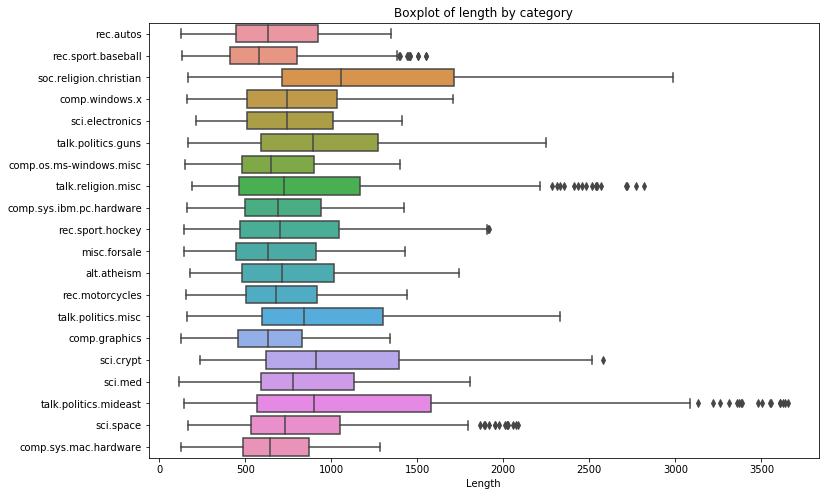

In [76]:
plt.figure(figsize=(12,8))
sns.boxplot(data = new_dict_df_85, orient='h')
plt.xlabel("Length")
plt.title("Boxplot of length by category")
plt.show()

In [69]:
class TextProcess():
    
    def __init__(self, model):
        self.model = model
        self.vectorizer = CountVectorizer(ngram_range = (1,1), min_df=0, max_df=0.75)
        self.tfidf = TfidfTransformer(norm='l2', sublinear_tf = True)
        print(f"-------------------{str(self.model).split('(')[0]}---------------------")
        
        
    def fit(self, train_data):
        start_time = time.time()
        self.train_data = train_data
        self.text_clf = Pipeline([('vect',self.vectorizer),('tfidf',self.tfidf),('clf',self.model)])
        self.text_clf.fit(self.train_data.data,self.train_data.target)
        self.time = (time.time()-start_time)
        print(f"Time to fit: {(time.time()-start_time):.3f}s")
        
    def predict(self, test_data):
        self.test_data = test_data
        self.test = self.test_data.data
        self.predicted = self.text_clf.predict(self.test)
        self.accuracy = np.mean(self.predicted == self.test_data.target)
        print(f"{str(self.model).split('(')[0]} accuracy: {self.accuracy*100:.2f}%")
        
    def classification_report(self):
        print(metrics.classification_report(self.test_data.target,self.predicted,target_names=self.test_data.target_names))
        
    def confusion_matrix(self):
        self.conf_matrix = metrics.confusion_matrix(self.test_data.target, self.predicted)
        for i,j in zip(self.conf_matrix,self.test_data.target_names):
            print(j)
            print(i)
            
    def get_words(self):
        self.words =  self.vectorizer.get_feature_names()
        self.weights = self.model.coef_.argsort()[:, ::-1]
        self.most_common = defaultdict(list)
        for i,category in enumerate(self.test_data.target_names):
            print(f"Category {category}:"),
            for ind in self.weights[i, :10]:
                self.most_common[i].append(self.words[ind])
                print(f' {self.words[ind]}'),
            print("\n")

In [10]:
model_list = [AdaBoostClassifier(learning_rate=0.5, n_estimators=160, base_estimator=DecisionTreeClassifier(max_depth=1)), AdaBoostClassifier(learning_rate=0.5, n_estimators=160, base_estimator=DecisionTreeClassifier(max_depth=2)), AdaBoostClassifier(learning_rate=0.5, n_estimators=160, base_estimator=DecisionTreeClassifier(max_depth=3)), AdaBoostClassifier(learning_rate=0.5, n_estimators=160, base_estimator=DecisionTreeClassifier(max_depth=4))]

In [11]:
time_list = []
accuracy_list = []
for model in model_list:
    processor = TextProcess(model)
    processor.fit(news_train)
    processor.predict(news_test)
    processor.classification_report()
    processor.confusion_matrix()
    time_list.append(processor.time)
    accuracy_list.append(processor.accuracy*100)

-------------------AdaBoostClassifier---------------------
Time to fit: 62.687s
AdaBoostClassifier accuracy: 47.23%
                          precision    recall  f1-score   support

             alt.atheism       0.68      0.34      0.46       319
           comp.graphics       0.48      0.38      0.42       389
 comp.os.ms-windows.misc       0.60      0.43      0.50       394
comp.sys.ibm.pc.hardware       0.50      0.16      0.24       392
   comp.sys.mac.hardware       0.68      0.46      0.55       385
          comp.windows.x       0.76      0.44      0.56       395
            misc.forsale       0.86      0.69      0.76       390
               rec.autos       0.74      0.45      0.56       396
         rec.motorcycles       0.91      0.59      0.71       398
      rec.sport.baseball       0.53      0.46      0.50       397
        rec.sport.hockey       0.88      0.50      0.64       399
               sci.crypt       0.92      0.66      0.77       396
         sci.electronics 

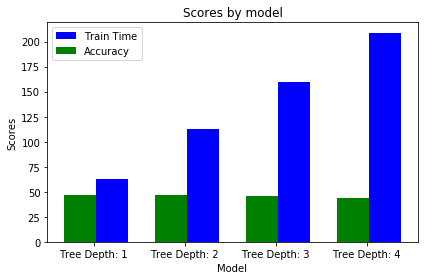

In [12]:
n_groups = len(time_list)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
rects1 = plt.bar(index+bar_width, time_list, bar_width, alpha=1, label='Train Time', color='b')
rects2 = plt.bar(index, accuracy_list, bar_width, alpha=1, label='Accuracy', color='g')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Scores by model')
plt.xticks(index + bar_width-0.2, ('Tree Depth: 1', 'Tree Depth: 2', 'Tree Depth: 3', 'Tree Depth: 4'))
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
model_list = [LogisticRegression(multi_class='auto', solver='liblinear',penalty='l2', C=6.3), DecisionTreeClassifier(criterion = 'gini', min_samples_split=92, splitter='random', min_samples_leaf=1), LinearSVC(C = 1, loss='squared_hinge', penalty='l2'), AdaBoostClassifier(learning_rate=0.5, n_estimators=160, base_estimator=DecisionTreeClassifier(max_depth=1)), RandomForestClassifier(min_samples_split=22, min_samples_leaf=1, n_estimators=600)]

In [60]:
processor = TextProcess(LinearSVC(C = 1, loss='squared_hinge', penalty='l2'))
processor.fit(news_train)
processor.predict(news_test)


-------------------LinearSVC---------------------
Time to fit: 6.137s
LinearSVC accuracy: 83.13%


In [61]:
processor.get_words()

Category alt.atheism:
 atheists
 atheism
 islamic
 rushdie
 keith
 islam
 thoughts
 bobby
 okcforum
 ingles


Category comp.graphics:
 graphics
 3d
 3do
 tiff
 images
 pov
 image
 cview
 polygon
 sphere


Category comp.os.ms-windows.misc:
 windows
 cica
 win3
 win
 nt
 file
 ini
 driver
 risc
 download


Category comp.sys.ibm.pc.hardware:
 gateway
 ide
 pc
 monitors
 bus
 486
 bios
 scsi
 vlb
 monitor


Category comp.sys.mac.hardware:
 mac
 apple
 quadra
 duo
 powerbook
 centris
 iisi
 lc
 lciii
 adb


Category comp.windows.x:
 motif
 server
 x11r5
 widget
 xterm
 window
 lcs
 xlib
 xpert
 expo


Category misc.forsale:
 sale
 forsale
 shipping
 wanted
 offer
 sell
 asking
 interested
 price
 condition


Category rec.autos:
 car
 cars
 warning
 oil
 automotive
 toyota
 vw
 dealer
 dumbest
 auto


Category rec.motorcycles:
 dod
 bike
 bikes
 motorcycle
 ride
 bmw
 motorcycles
 riding
 helmet
 kawasaki


Category rec.sport.baseball:
 baseball
 phillies
 cubs
 sox
 stadium
 pitching
 brave

In [10]:
time_list = []
accuracy_list = []
for model in model_list:
    processor = TextProcess(model)
    processor.fit(news_train)
    processor.predict(news_test)
    processor.classification_report()
    processor.confusion_matrix()
    time_list.append(processor.time)
    accuracy_list.append(processor.accuracy*100)

-------------------LogisticRegression---------------------
Time to fit: 11.648s
LogisticRegression accuracy: 82.25%
                          precision    recall  f1-score   support

             alt.atheism       0.78      0.71      0.74       319
           comp.graphics       0.71      0.79      0.75       389
 comp.os.ms-windows.misc       0.76      0.72      0.74       394
comp.sys.ibm.pc.hardware       0.74      0.74      0.74       392
   comp.sys.mac.hardware       0.81      0.84      0.82       385
          comp.windows.x       0.86      0.75      0.80       395
            misc.forsale       0.82      0.88      0.85       390
               rec.autos       0.89      0.87      0.88       396
         rec.motorcycles       0.91      0.94      0.92       398
      rec.sport.baseball       0.88      0.92      0.90       397
        rec.sport.hockey       0.92      0.95      0.94       399
               sci.crypt       0.93      0.89      0.91       396
         sci.electronics 

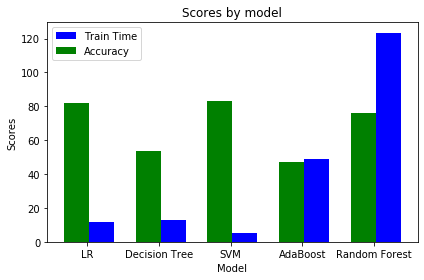

In [11]:
n_groups = len(time_list)
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
rects1 = plt.bar(index+bar_width, time_list, bar_width, alpha=1, label='Train Time', color='b')
rects2 = plt.bar(index, accuracy_list, bar_width, alpha=1, label='Accuracy', color='g')
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Scores by model')
plt.xticks(index + bar_width-0.2, ('LR', 'Decision Tree', 'SVM', 'AdaBoost', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
def report(results, top=3):
    for i in range(1, top+1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [216]:
param_dist = {'tfidf__norm' : ['l1','l2'],
              'tfidf__sublinear_tf' : [True, False]
            }
clf = LogisticRegression(multi_class='auto', solver='liblinear',penalty='l2', C=6.3)
text_clf = Pipeline([('vect',CountVectorizer(ngram_range = (1,1), min_df=0, max_df=0.75)),('tfidf',TfidfTransformer(norm='l2', sublinear_tf = True)),('clf',clf)])
random_search = GridSearchCV(text_clf, param_grid = param_dist, cv=5)
start_time = time.time()
random_search.fit(news_train.data, news_train.target)
print(f"GridSearchCV took {(time.time() - start_time):.2f} seconds for {len(random_search.cv_results_['params'])} parameter settings.")
report(random_search.cv_results_)

GridSearchCV took 259.60 seconds for 4 parameter settings.
Model with rank: 1
Mean validation score: 0.885 (std: 0.006)
Parameters: {'tfidf__norm': 'l2', 'tfidf__sublinear_tf': True}

Model with rank: 2
Mean validation score: 0.874 (std: 0.008)
Parameters: {'tfidf__norm': 'l2', 'tfidf__sublinear_tf': False}

Model with rank: 3
Mean validation score: 0.773 (std: 0.007)
Parameters: {'tfidf__norm': 'l1', 'tfidf__sublinear_tf': True}



In [211]:
param_dist = {#'clf__min_samples_split': range(92,len(news_train.data[0])-1,21),
             'clf__splitter': ['best', 'random'],
             'clf__min_samples_leaf' : range(1, 100, 10)}
clf = DecisionTreeClassifier(criterion = 'gini', min_samples_split=92, splitter='random', min_samples_leaf=1)
text_clf = Pipeline([('vect',CountVectorizer(ngram_range = (1,1), min_df=0, max_df=0.75)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=5)
start_time = time.time()
grid_search.fit(news_train.data, news_train.target)
print(f"GridSearchCV took {(time.time() - start_time):.2f} seconds for {len(random_search.cv_results_['params'])} parameter settings.")
report(grid_search.cv_results_)

GridSearchCV took 955.48 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.599 (std: 0.007)
Parameters: {'clf__min_samples_leaf': 1, 'clf__splitter': 'random'}

Model with rank: 2
Mean validation score: 0.596 (std: 0.010)
Parameters: {'clf__min_samples_leaf': 1, 'clf__splitter': 'best'}

Model with rank: 3
Mean validation score: 0.572 (std: 0.006)
Parameters: {'clf__min_samples_leaf': 11, 'clf__splitter': 'best'}



In [212]:
param_dist = {'clf__C' : np.logspace(-0.3,0.9, 15),
}

clf = LinearSVC(loss='squared_hinge', penalty='l2')
text_clf = Pipeline([('vect',CountVectorizer(ngram_range = (1,1), min_df=0, max_df=0.75)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=5)
start_time = time.time()
grid_search.fit(news_train.data, news_train.target)
print(f"GridSearchCV took {(time.time() - start_time):.2f} seconds for {len(random_search.cv_results_['params'])} parameter settings.")
report(grid_search.cv_results_)

GridSearchCV took 624.74 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.885 (std: 0.007)
Parameters: {'clf__C': 0.7437527275659046}

Model with rank: 2
Mean validation score: 0.885 (std: 0.007)
Parameters: {'clf__C': 0.6105402296585328}

Model with rank: 2
Mean validation score: 0.885 (std: 0.006)
Parameters: {'clf__C': 0.9060305822453376}

Model with rank: 2
Mean validation score: 0.885 (std: 0.007)
Parameters: {'clf__C': 1.637893706954064}

Model with rank: 2
Mean validation score: 0.885 (std: 0.008)
Parameters: {'clf__C': 1.9952623149688795}



In [214]:
param_dist = {'clf__n_estimators' : range(160, 360, 50),
              'clf__base_estimator' : [DecisionTreeClassifier(max_depth=2, min_samples_split=92), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)]
}

clf = AdaBoostClassifier(learning_rate=0.5, n_estimators=160, base_estimator=DecisionTreeClassifier(max_depth=1))
text_clf = Pipeline([('vect',CountVectorizer(ngram_range = (1,1), min_df=0, max_df=0.75)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=5)
start_time = time.time()
grid_search.fit(news_train.data, news_train.target)
print(f"GridSearchCV took {(time.time() - start_time):.2f} seconds for {len(random_search.cv_results_['params'])} parameter settings.")
report(grid_search.cv_results_)

GridSearchCV took 8375.64 seconds for 10 parameter settings.
Model with rank: 1
Mean validation score: 0.528 (std: 0.020)
Parameters: {'clf__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'clf__n_estimators': 160}

Model with rank: 2
Mean validation score: 0.524 (std: 0.021)
Parameters: {'clf__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'clf__n_estimators': 2

In [215]:
param_dist = {'clf__n_estimators' : range(400, 700, 50),
              'clf__min_samples_leaf' : range(1, 100, 10)
}

clf = RandomForestClassifier(min_samples_split=22, min_samples_leaf=1, n_estimators=600)
text_clf = Pipeline([('vect',CountVectorizer(ngram_range = (1,1), min_df=0, max_df=0.75)),('tfidf',TfidfTransformer()),('clf',clf)])
grid_search = GridSearchCV(text_clf, param_grid = param_dist, cv=5)
start_time = time.time()
grid_search.fit(news_train.data, news_train.target)
print(f"GridSearchCV took {(time.time() - start_time):.2f} seconds for {len(random_search.cv_results_['params'])} parameter settings.")
report(grid_search.cv_results_)

GridSearchCV took 6602.64 seconds for 10 parameter settings.
Model with rank: 1
Mean validation score: 0.810 (std: 0.008)
Parameters: {'clf__min_samples_leaf': 1, 'clf__n_estimators': 600}

Model with rank: 2
Mean validation score: 0.808 (std: 0.010)
Parameters: {'clf__min_samples_leaf': 1, 'clf__n_estimators': 400}

Model with rank: 3
Mean validation score: 0.808 (std: 0.011)
Parameters: {'clf__min_samples_leaf': 1, 'clf__n_estimators': 650}

